In [14]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import UnitaryGate

import matplotlib.pyplot as plt

import numpy as np

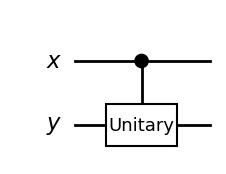

In [22]:
#implementing a single-qubit controlled-U gate
def controlled_U_gate(U):
    quantum_registerXs = QuantumRegister(size=1, name="x")
    quantum_registerY = QuantumRegister(size=1, name="y")
    #ancilla_register = AncillaRegister(size=1, name="y")

    cUckt = QuantumCircuit(quantum_registerXs,quantum_registerY, name="controlled-U")

    U = UnitaryGate(U).control(1)
    cUckt.append(U, [quantum_registerXs[0], quantum_registerY[0]])
    
    return cUckt

cUckt = controlled_U_gate(Operator([[1, 0], [0, 1]]))
cUckt.draw(output="mpl", style="bw")

In [23]:
#trying to implement multi-controlled-U gate
def multi_controlled_U_gate(U, n):
    quantum_registerXs = QuantumRegister(size=n, name="x")
    quantum_registerY = QuantumRegister(size=1, name="y")
    #ancilla_register = AncillaRegister(size=n, name="y")

    mcUckt = QuantumCircuit(quantum_registerXs, quantum_registerY, name="multi-controlled-U")

    U = UnitaryGate(U).control(n)
    mcUckt.append(U, [quantum_registerXs[i] for i in range(n)] + [quantum_registerY[0]])
    
    return mcUckt

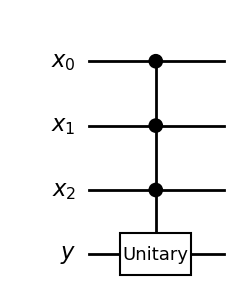

In [25]:
mcUckt = multi_controlled_U_gate(Operator([[1, 0], [0, 1]]),3)
mcUckt.draw(output="mpl", style="bw")